<a href="https://colab.research.google.com/github/Amira-Hassan24/Cell-image-For-Detecting-Malaria/blob/main/Detecting_malaria1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [3]:
import os
import cv2
import numpy as np
from skimage.feature import hog
from sklearn.model_selection import train_test_split, StratifiedKFold, cross_val_score
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.cluster import KMeans
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, roc_curve, auc
import matplotlib.pyplot as plt
from tqdm import tqdm

# 1. Load limited subset of images

In [4]:

data_dir = "/content/cell_images/cell_images"
categories = ["Parasitized", "Uninfected"]

images = []
labels = []
limit = 3400

for category in categories:
    path = os.path.join(data_dir, category)
    class_num = categories.index(category)

    img_list = os.listdir(path)[:limit]

    for img_name in tqdm(img_list, desc=f"Loading {category}"):
        img_path = os.path.join(path, img_name)
        img = cv2.imread(img_path)
        if img is None:
            continue

        img = cv2.resize(img, (150, 150))
        # gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
        # eq = cv2.equalizeHist(gray)

        gamma=1.4
        invGamma = 1.0 / gamma
        table = np.array([((i / 255.0) ** invGamma) * 255 for i in np.arange(0, 256)]).astype("uint8")
        img = cv2.LUT(img, table)

        images.append(img)

        labels.append(class_num)

images = np.array(images)
labels = np.array(labels)


Loading Uninfected: 100%|██████████| 3400/3400 [00:09<00:00, 342.38it/s]


# 2. Extract HOG Features

In [5]:
batch_size = 100
hog_features = []

for i in range(0, len(images), batch_size):
    batch = images[i:i+batch_size]
    for img in tqdm(batch, desc=f'Processing batch {i//batch_size+1}'):
        feature = []
        for ch in cv2.split(img):
            f = hog(ch, orientations=9, pixels_per_cell=(8,8),
                    cells_per_block=(2,2), block_norm='L2-Hys')
            feature.extend(f)
        hog_features.append(feature)

hog_features = np.array(hog_features)



Processing batch 68: 100%|██████████| 98/98 [00:02<00:00, 46.74it/s]


# 3. Split FIRST, then scaling

In [6]:
X_train, X_test, y_train, y_test = train_test_split(
    hog_features, labels,
    test_size=0.2, random_state=42, stratify=labels
)

scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

# 4. Visualization images & images after preprocessing & feature extraction

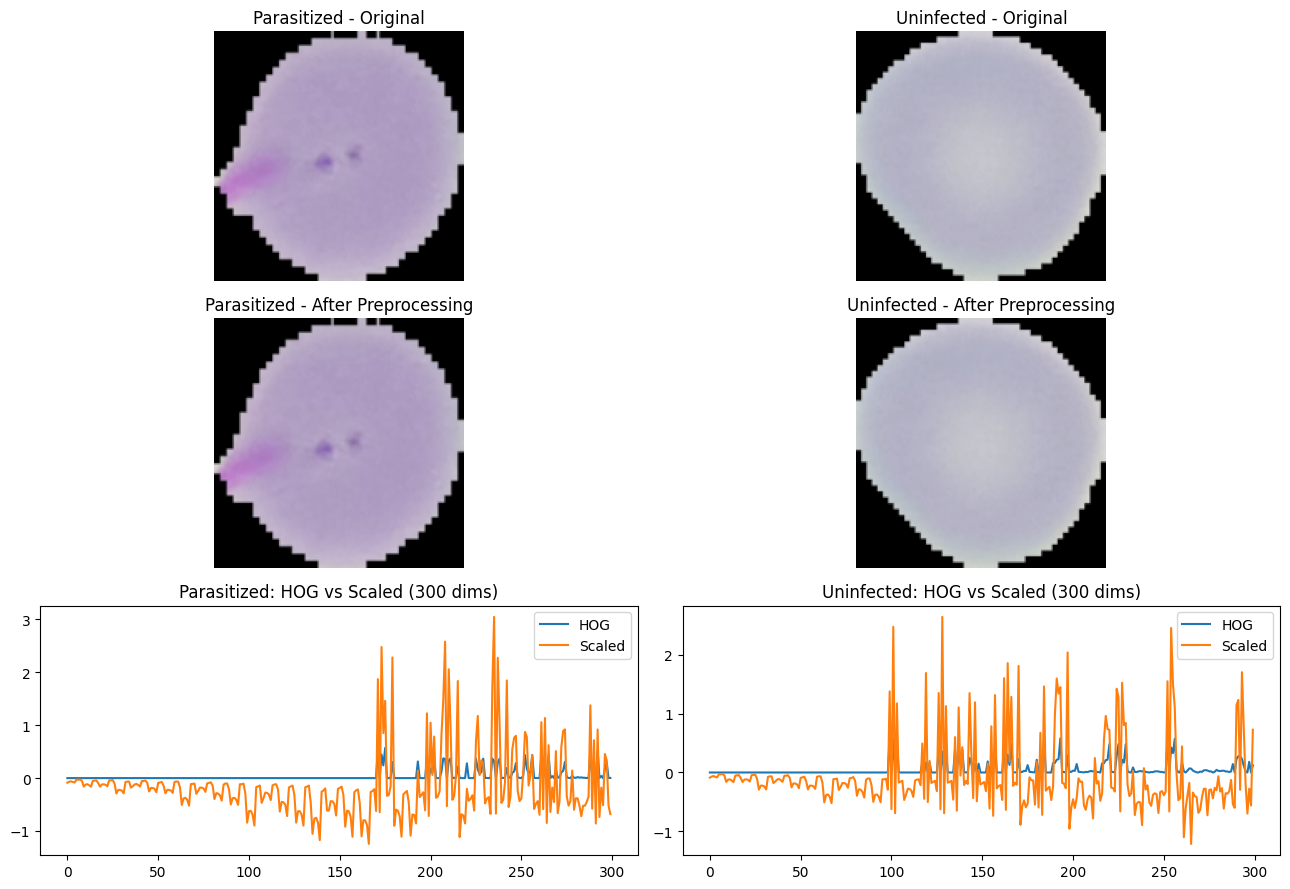

In [9]:
import matplotlib.pyplot as plt
import cv2
import numpy as np
from skimage import exposure

infected_idx = np.where(labels == 0)[0][0]
healthy_idx = np.where(labels == 1)[0][0]

infected_img = images[infected_idx]
healthy_img = images[healthy_idx]


infected_pre = images[infected_idx]
healthy_pre = images[healthy_idx]

infected_hog = hog_features[infected_idx]
healthy_hog = hog_features[healthy_idx]

infected_hog_vis = infected_hog[:300]
healthy_hog_vis = healthy_hog[:300]

infected_scaled = scaler.transform([infected_hog])[0][:300]
healthy_scaled = scaler.transform([healthy_hog])[0][:300]



plt.figure(figsize=(13, 9))

plt.subplot(3, 2, 1)
plt.imshow(cv2.cvtColor(infected_img, cv2.COLOR_BGR2RGB))
plt.title("Parasitized - Original")
plt.axis("off")

plt.subplot(3, 2, 2)
plt.imshow(cv2.cvtColor(healthy_img, cv2.COLOR_BGR2RGB))
plt.title("Uninfected - Original")
plt.axis("off")



plt.subplot(3, 2, 3)
plt.imshow(cv2.cvtColor(infected_pre, cv2.COLOR_BGR2RGB))
plt.title("Parasitized - After Preprocessing")
plt.axis("off")

plt.subplot(3, 2, 4)
plt.imshow(cv2.cvtColor(healthy_pre, cv2.COLOR_BGR2RGB))
plt.title("Uninfected - After Preprocessing")
plt.axis("off")


plt.subplot(3, 2, 5)
plt.plot(infected_hog_vis)
plt.plot(infected_scaled)
plt.title("Parasitized: HOG vs Scaled (300 dims)")
plt.legend(["HOG", "Scaled"])

plt.subplot(3, 2, 6)
plt.plot(healthy_hog_vis)
plt.plot(healthy_scaled)
plt.title("Uninfected: HOG vs Scaled (300 dims)")
plt.legend(["HOG", "Scaled"])

plt.tight_layout()
plt.show()

# 5. Logistic Regression + CV

In [7]:
log_reg = LogisticRegression(max_iter=1000, C=1.0, solver='lbfgs')

cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
cv_scores = cross_val_score(log_reg, X_train, y_train, cv=cv)

print("\nCross-validation accuracy:", cv_scores)
print("Mean CV accuracy:", cv_scores.mean())

log_reg.fit(X_train, y_train)

y_pred = log_reg.predict(X_test)
y_prob = log_reg.predict_proba(X_test)[:, 1]


Cross-validation accuracy: [0.80422794 0.77665441 0.77205882 0.77276909 0.77920883]
Mean CV accuracy: 0.7809838194707506


# 6. Confusion Matrix with TP / FP / FN / TN

In [8]:
cm = confusion_matrix(y_test, y_pred)

tn, fp, fn, tp = cm.ravel()

print("\nConfusion Matrix:")
print("TN =", tn, " | FP =", fp)
print("FN =", fn, " | TP =", tp)

print("\nDetailed CM:")
print(cm)

print("\nClassification Report:")
print(classification_report(y_test, y_pred, target_names=categories))


Confusion Matrix:
TN = 508  | FP = 172
FN = 126  | TP = 554

Detailed CM:
[[508 172]
 [126 554]]

Classification Report:
              precision    recall  f1-score   support

 Parasitized       0.80      0.75      0.77       680
  Uninfected       0.76      0.81      0.79       680

    accuracy                           0.78      1360
   macro avg       0.78      0.78      0.78      1360
weighted avg       0.78      0.78      0.78      1360



# *7*. ROC Curve

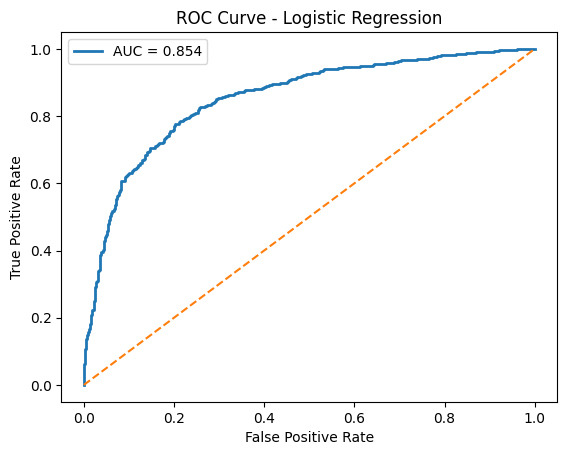

In [9]:
fpr, tpr, thresholds = roc_curve(y_test, y_prob)
roc_auc = auc(fpr, tpr)

plt.figure()
plt.plot(fpr, tpr, lw=2, label=f"AUC = {roc_auc:.3f}")
plt.plot([0, 1], [0, 1], '--')
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve - Logistic Regression")
plt.legend()
plt.show()




# 8. K-Means Clustering

In [10]:
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
from sklearn.metrics import adjusted_rand_score, silhouette_score
from sklearn.metrics import confusion_matrix
# import sklearn.utils.linear_assignment_
import numpy as np
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA

# ---------------------
# Scaling
# ---------------------
scaler = StandardScaler()
hog_scaled = scaler.fit_transform(hog_features)

# ---------------------
# KMeans++
# ---------------------
kmeans = KMeans(
    n_clusters=2,
    init="k-means++",
    n_init=20,
    max_iter=300,
    random_state=42
)

clusters = kmeans.fit_predict(hog_scaled)

print("Cluster counts:", np.bincount(clusters))


Cluster counts: [2775 4023]


# 9. **PCA Visualisation**

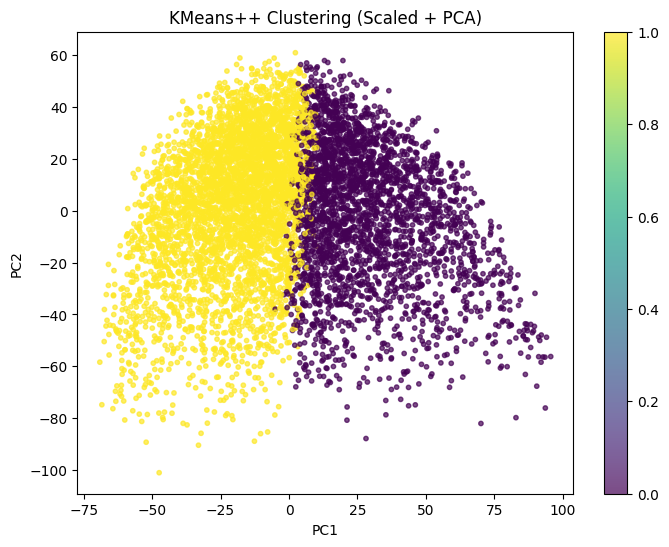

In [11]:
pca = PCA(n_components=2)
X_pca = pca.fit_transform(hog_scaled)

plt.figure(figsize=(8, 6))
plt.scatter(
    X_pca[:, 0], X_pca[:, 1],
    c=clusters, cmap="viridis", s=10, alpha=0.7
)
plt.title("KMeans++ Clustering (Scaled + PCA)")
plt.xlabel("PC1")
plt.ylabel("PC2")
plt.colorbar()
plt.show()

# 10. (ARI + Silhouette) For K-Means

In [12]:
ari = adjusted_rand_score(labels, clusters)
sil = silhouette_score(hog_scaled, clusters)

print("Adjusted Rand Index:", ari)
print("Silhouette Score:", sil)
from scipy.optimize import linear_sum_assignment

def clustering_accuracy(true_labels, cluster_labels):

    cm = confusion_matrix(true_labels, cluster_labels)

    # Hungarian algorithm
    row_ind, col_ind = linear_sum_assignment(-cm)

    correct = cm[row_ind, col_ind].sum()
    accuracy = correct / len(true_labels)
    return accuracy

Adjusted Rand Index: 0.0022146393780961677
Silhouette Score: 0.026185574624692474


# 11. (Accuracy + Misclustring + confuision Matrix ) For K-Means

In [14]:
acc = clustering_accuracy(labels, clusters)
print("Clustering Accuracy:", acc)
def misclustering_rate(true_labels, cluster_labels):
    return 1 - clustering_accuracy(true_labels, cluster_labels)

print("Misclustering rate:", misclustering_rate(labels, clusters))
from sklearn.metrics import confusion_matrix

# confusion matrix between true labels and kmeans clusters
cm = confusion_matrix(labels, clusters)

print("\n===== Confusion Matrix (True vs Cluster) =====")
print(cm)


print("\nFormatted Confusion Matrix:")
print(f"            Cluster 0   Cluster 1")
print(f"True 0 -->    {cm[0][0]:5d}        {cm[0][1]:5d}")
print(f"True 1 -->    {cm[1][0]:5d}        {cm[1][1]:5d}")

Clustering Accuracy: 0.5242718446601942
Misclustering rate: 0.47572815533980584

===== Confusion Matrix (True vs Cluster) =====
[[1470 1929]
 [1305 2094]]

Formatted Confusion Matrix:
            Cluster 0   Cluster 1
True 0 -->     1470         1929
True 1 -->     1305         2094
